<a href="https://colab.research.google.com/github/mgzzl/stylegan2-ada-pytorch/blob/main/nft_creator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://colab.research.google.com/github/jeffheaton/present/blob/master/youtube/gan/heatonresearch_gan_kit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install Software

Some software must be installed into Colab, for this notebook to work. We are specificially using these technologies:

* [Training Generative Adversarial Networks with Limited Data](https://arxiv.org/abs/2006.06676)
Tero Karras, Miika Aittala, Janne Hellsten, Samuli Laine, Jaakko Lehtinen, Timo Aila
* [One millisecond face alignment with an ensemble of regression trees](https://www.cv-foundation.org/openaccess/content_cvpr_2014/papers/Kazemi_One_Millisecond_Face_2014_CVPR_paper.pdf) Vahid Kazemi, Josephine Sullivan


In [ ]:
!rm -r /content/stylegan2-ada-pytorch/

In [1]:
!git clone https://github.com/mgzzl/stylegan2-ada-pytorch.git

Cloning into 'stylegan2-ada-pytorch'...
remote: Enumerating objects: 527, done.
remote: Counting objects: 100% (270/270), done.
remote: Compressing objects: 100% (53/53), done.
remote: Total 527 (delta 232), reused 217 (delta 217), pack-reused 257
Receiving objects: 100% (527/527), 8.40 MiB | 12.26 MiB/s, done.
Resolving deltas: 100% (307/307), done.


In [2]:
%cd /content/stylegan2-ada-pytorch

/content/stylegan2-ada-pytorch


In [3]:
import os
import sys
import torch

!pip install ninja
!pip install opensimplex

import dnnlib
import legacy
import PIL.Image
import numpy as np
import imageio
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt
import cv2
import numpy as np

def display_lowres(img):
  plt.imshow(img)
  plt.title('poster-gan')
  plt.show()

def seed2vec(g, seed):
  return np.random.RandomState(seed).randn(1, g.z_dim)

def load_vec(filename):
  result = np.load(filename)
  return result if 'w' not in result else result['w']
  
def save_vec(filename, lvec):
  np.save(filename,lvec)

def to_image(img):
  return PIL.Image.fromarray(img, 'RGB')

def render_gan(G, device, lvec, label=None, truncation_psi=1, noise_mode='const'):
  # noise mode 'const', 'random', 'none'
  z = torch.from_numpy(lvec).to(device)
  if label is None: label = torch.zeros([1, G.c_dim], device=device)
  print(lvec.shape)
  if len(lvec.shape) == 2:
    img = G(z, label, truncation_psi=truncation_psi, noise_mode=noise_mode)
  else:
    img = G.synthesis(z, noise_mode=noise_mode)
  
  img = (img.permute(0, 2, 3, 1) * 127.5 + 128).clamp(0, 255).to(torch.uint8)
  return PIL.Image.fromarray(img[0].cpu().numpy(), 'RGB')

     |████████████████████████████████| 108 kB 5.3 MB/s 


# Load a Pretrained GAN

In [4]:
STYLEGAN2_PKL_URL = "https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/ffhq.pkl"
#STYLEGAN2_PKL_URL = "https://github.com/jeffheaton/pretrained-gan-fish/releases/download/1.0.0/fish-gan-2020-12-09.pkl"
#STYLEGAN2_PKL_URL = "https://github.com/jeffheaton/pretrained-gan-70s-scifi/releases/download/v1/70s-scifi-gan-2020-12-12.pkl"
#STYLEGAN2_PKL_URL = "https://github.com/jeffheaton/pretrained-merry-gan-mas/releases/download/v1/christmas-gan-2020-12-03.pkl"
#STYLEGAN2_PKL_URL = "https://github.com/jeffheaton/pretrained-gan-minecraft/releases/download/v1/minecraft-gan-2020-12-22.pkl"
#STYLEGAN2_PKL_URL = "./out/training-runs/posterGAN2/00000-..."

device = torch.device('cuda')
with dnnlib.util.open_url(STYLEGAN2_PKL_URL) as fp:
    G = legacy.load_network_pkl(fp)['G_ema'].requires_grad_(False).to(device) # type: ignore

# Generate GAN Images from Seeds

Generating image for seed 922098 (0/5) ...
(1, 512)


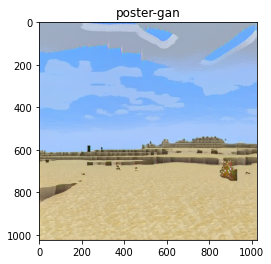

Generating image for seed 119952 (1/5) ...
(1, 512)


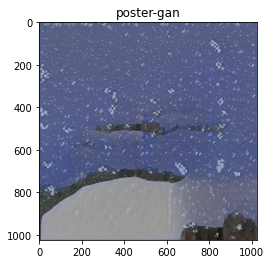

Generating image for seed 796225 (2/5) ...
(1, 512)


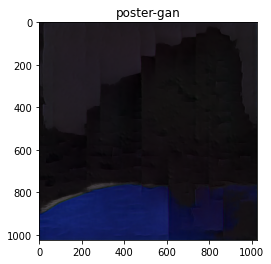

Generating image for seed 810016 (3/5) ...
(1, 512)


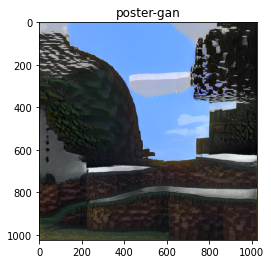

Generating image for seed 836637 (4/5) ...
(1, 512)


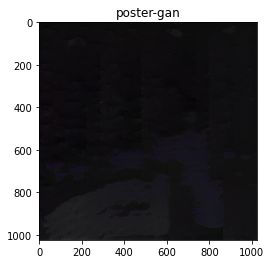

In [7]:
import random

seeds = random.sample(range(0, 999999), 5)
OUTDIR = "/out/generated_images"

# Create directory
try:
    os.makedirs(OUTDIR)
except OSError:
    pass

# Generate images.

for seed_idx, seed in enumerate(seeds):
  print('Generating image for seed %d (%d/%d) ...' % (seed, seed_idx, len(seeds)))
  lv = seed2vec(G, seed)
  save_vec(f'vec-{seed}', lv)
  img = render_gan(G, device, lv)
  img.save(f'{OUTDIR}/seed{seed:04d}.png') # Save it
  #display(img2) # Display hi-res
  display_lowres(img)

In [6]:
import torch
import dnnlib
import legacy
import PIL.Image
import numpy as np
import imageio
from tqdm.notebook import tqdm

STEPS = 150
FPS = 30
FREEZE_STEPS = 30
path = "/content/stylegan2-ada-pytorch"

lvec = [np.load('vec-240333.npy'), np.load('vec-274115.npy'), np.load('vec-464321.npy'), np.load('vec-786991.npy'), np.load('vec-985374.npy')]
network_pkl = STYLEGAN2_PKL_URL
device = torch.device('cuda')
with dnnlib.util.open_url(network_pkl) as fp:
    G = legacy.load_network_pkl(fp)['G_ema'].requires_grad_(False).to(device) # type: ignore

target_uint8 = np.array([1024,1024,3], dtype=np.uint8)

video = imageio.get_writer('/content/movie.mp4', mode='I', fps=FPS, codec='libx264', bitrate='16M')

for i in range(len(lvec)-1):
  lvec1 = lvec[i]
  lvec2 = lvec[i+1]

  diff = lvec2 - lvec1
  step = diff / STEPS
  current = lvec1.copy()

  for j in tqdm(range(STEPS)):
    z = torch.from_numpy(current).to(device)
    label=None
    truncation_psi=1
    noise_mode='const'
    if label is None: label = torch.zeros([1, G.c_dim], device=device)
    synth_image = G(z, label, truncation_psi=truncation_psi, noise_mode=noise_mode)
    synth_image = (synth_image + 1) * (255/2)
    synth_image = synth_image.permute(0, 2, 3, 1).clamp(0, 255).to(torch.uint8)[0].cpu().numpy()

    repeat = FREEZE_STEPS if (j==0 and i==0) or (j==(STEPS-1) and i==(len(lvec)-2)) else 1
    
    for i in range(repeat):
      video.append_data(synth_image)
    current = current + step


video.close()

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

## Load a Saved Latent Vector and Display

In [ ]:
lvec = load_vec('/content/drive/MyDrive/data/gan/lvec/jeff/projected_w.npz')
img = render_gan(G, device, lvec)
display_lowres(img)

# Convert Image to a GAN

First, we convert the source to a GAN latent vector.  This process will take several minutes.

In [ ]:
SOURCE_NAME = "source-target.png"
OUT = "./out/projected_img/"

cmd = f"python ./projector.py --seed 303 --save-video 0 --num-steps 1000 --outdir={OUT} --target={SOURCE_NAME} --network={STYLEGAN2_PKL_URL}"
!{cmd}

In [ ]:
import cv2
import os
from matplotlib import pyplot as plt

img_gan_source = cv2.imread(os.path.join(OUT,'proj.png'))
img = cv2.cvtColor(img_gan_source, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.title('poster-gan')
plt.show()

# Generate NFT

The following code builds the latent_vectors and prints image for every seed in complete training_process

## Presettings
Some Variables for Process

In [5]:
import os
from pathlib import Path
import random

# To create a list of random integer values:
NFT_SEEDS = random.sample(range(0, 999999), 100)

# create a list of chosen integer values: 
#NFT_SEEDS = [1, 20, 400, 9]

# presettings directory
network_dir = "./"
outdir = "./out/generated-poster-nfts/" # "/" nach Directory wichtig!
print(f"Outputdirectory: {outdir}\nNetworkdirectory: {network_dir}\nSEEDS: {NFT_SEEDS}")

Outputdirectory: ./out/generated-poster-nfts/
Networkdirectory: ./
SEEDS: [433943, 819937, 163190, 824714, 385822, 427391, 823974, 832798, 455987, 153944, 357387, 491582, 104776, 861072, 499122, 608739, 121937, 981929, 751020, 90290, 581836, 157060, 179313, 88478, 136477, 432907, 693183, 102546, 563288, 392576, 504435, 130918, 648108, 914411, 249968, 159194, 749818, 748094, 772332, 622056, 280436, 159440, 498059, 807906, 951281, 289212, 70218, 178651, 590939, 303044, 239157, 112400, 519533, 425516, 768862, 124528, 108641, 931594, 836578, 965995, 569307, 66792, 841757, 614027, 857742, 559600, 312982, 710325, 953510, 452121, 608721, 122976, 338572, 425125, 664939, 943612, 330826, 305614, 922743, 296415, 892856, 703985, 779654, 432692, 190824, 844449, 628239, 386149, 919651, 899781, 599917, 159982, 795687, 11971, 670802, 502984, 833690, 81030, 313375, 707624]


## Generate Images and their latent-vector for every training_step

In [12]:
import os
from pathlib import Path

#Go through every Seed in Seeds
for NFT_SEED in NFT_SEEDS:
  #looking for trained networks
    for file in os.listdir(network_dir):
            if file.endswith(".py"):
                pkl = os.path.join(network_dir, file)
                pkl_name = Path(pkl).stem
                cmd = f"python ./generate.py --seeds {NFT_SEED} --outdir={outdir}seed-{NFT_SEED}/{pkl_name} --network={pkl}"
                print(cmd)
                # !{cmd}
            

python ./generator.py --seed 254462 --outdir=./out/generated-poster-nfts/seed-254462/dataset_tool --network=./dataset_tool.py
python ./generator.py --seed 254462 --outdir=./out/generated-poster-nfts/seed-254462/train --network=./train.py
python ./generator.py --seed 254462 --outdir=./out/generated-poster-nfts/seed-254462/legacy --network=./legacy.py
python ./generator.py --seed 254462 --outdir=./out/generated-poster-nfts/seed-254462/style_mixing --network=./style_mixing.py
python ./generator.py --seed 254462 --outdir=./out/generated-poster-nfts/seed-254462/generate --network=./generate.py
python ./generator.py --seed 254462 --outdir=./out/generated-poster-nfts/seed-254462/apply_factor --network=./apply_factor.py
python ./generator.py --seed 254462 --outdir=./out/generated-poster-nfts/seed-254462/export_weights --network=./export_weights.py
python ./generator.py --seed 254462 --outdir=./out/generated-poster-nfts/seed-254462/combine_npz --network=./combine_npz.py
python ./generator.py --

In [11]:
!pwd

/content/stylegan2-ada-pytorch


In [6]:
pkl_name = Path(STYLEGAN2_PKL_URL).stem
for NFT_SEED in NFT_SEEDS:
  cmd = f"python ./generate.py --seeds {NFT_SEED} --outdir={outdir}seed-{NFT_SEED}/{pkl_name} --network={STYLEGAN2_PKL_URL}"
  !{cmd}

Generating image for seed 951281 (0/1) ...
Setting up PyTorch plugin "bias_act_plugin"... Done.
Setting up PyTorch plugin "upfirdn2d_plugin"... Done.
Loading networks from "https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/ffhq.pkl"...
Generating image for seed 289212 (0/1) ...
Setting up PyTorch plugin "bias_act_plugin"... Done.
Setting up PyTorch plugin "upfirdn2d_plugin"... Done.
Loading networks from "https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/ffhq.pkl"...
Generating image for seed 70218 (0/1) ...
Setting up PyTorch plugin "bias_act_plugin"... Done.
Setting up PyTorch plugin "upfirdn2d_plugin"... Done.
Loading networks from "https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/ffhq.pkl"...
Generating image for seed 178651 (0/1) ...
Setting up PyTorch plugin "bias_act_plugin"... Done.
Setting up PyTorch plugin "upfirdn2d_plugin"... Done.
Loading networks from "https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/ffhq.p

# Presettings
Some Variables for building the video

In [7]:
# presettings for building the video
STEPS = 150 #Steps between generated Images
FPS = 30 #How much frames per seconde?
FREEZE_STEPS = 0 #Freezing Steps for first_img before morphing to sec_img

# Build the Video

The following code builds a transition video between the two latent vectors previously obtained.

In [8]:
import os
import sys
import glob
import torch
import dnnlib
import legacy
import PIL.Image
import numpy as np
import imageio
from tqdm.notebook import tqdm

lvec_root_dir = outdir
print(F"root_dir: {lvec_root_dir}")
lvec_sub_dir = [os.path.join(lvec_root_dir, o) for o in os.listdir(lvec_root_dir)
                                            if os.path.isdir(os.path.join(lvec_root_dir, o))]
print(F"sub_dir: {lvec_sub_dir}")
for lv_sd in lvec_sub_dir:
    seed_dir = [os.path.join(lv_sd + "/", n + "/", file) for n in os.listdir(lv_sd)
                                                            if os.path.isdir(os.path.join(lv_sd, n))
                                                                for file in os.listdir(os.path.join(lv_sd, n))
                                                                    if file.endswith(".npy")]
    
    lvec_list=[]
    for s in range(len(seed_dir)):
        lvec_list.append(np.load(f'{seed_dir[s]}')) # setup latent-vector list for every founded latent vector inside of single seed
    #lvec_list.append(np.load(f'{seed_dir[0]}')) # add first latent-vector also to the last to create a loop
    print(seed_dir[:1])
    print(f"\nFound {len(seed_dir)} training_process_directories and loaded {len(lvec_list)} .npy files for {lv_sd}")
    lvec = lvec_list

    network_pkl = STYLEGAN2_PKL_URL
    device = torch.device('cuda')
    with dnnlib.util.open_url(network_pkl) as fp:
        G = legacy.load_network_pkl(fp)['G_ema'].requires_grad_(False).to(device) # type: ignore

    target_uint8 = np.array([1024,1024,3], dtype=np.uint8)

    video = imageio.get_writer(f'{lv_sd}/nft.mp4', mode='I', fps=FPS, codec='libx264', bitrate='16M')

    for i in range(len(lvec)-1):
        lvec1 = lvec[i]
        lvec2 = lvec[i+1]

        diff = lvec2 - lvec1
        step = diff / STEPS
        current = lvec1.copy()

        for j in tqdm(range(STEPS)):
            z = torch.from_numpy(current).to(device)
            label=None
            truncation_psi=1
            noise_mode='const'
            if label is None: label = torch.zeros([1, G.c_dim], device=device)
            synth_image = G(z, label, truncation_psi=truncation_psi, noise_mode=noise_mode)
            synth_image = (synth_image + 1) * (255/2)
            synth_image = synth_image.permute(0, 2, 3, 1).clamp(0, 255).to(torch.uint8)[0].cpu().numpy()

            repeat = FREEZE_STEPS if (j==0 and i==0) or (j==(STEPS-1) and i==(len(lvec)-2)) else 1
        
            for i in range(repeat):
                video.append_data(synth_image)
                current = current + step
    
    video.close()

root_dir: ./out/generated-poster-nfts/
sub_dir: ['./out/generated-poster-nfts/seed-563288', './out/generated-poster-nfts/seed-857742', './out/generated-poster-nfts/seed-748094', './out/generated-poster-nfts/seed-157060', './out/generated-poster-nfts/seed-432907', './out/generated-poster-nfts/seed-922743', './out/generated-poster-nfts/seed-833690', './out/generated-poster-nfts/seed-931594', './out/generated-poster-nfts/seed-498059', './out/generated-poster-nfts/seed-590939', './out/generated-poster-nfts/seed-919651', './out/generated-poster-nfts/seed-599917', './out/generated-poster-nfts/seed-338572', './out/generated-poster-nfts/seed-112400', './out/generated-poster-nfts/seed-914411', './out/generated-poster-nfts/seed-628239', './out/generated-poster-nfts/seed-312982', './out/generated-poster-nfts/seed-943612', './out/generated-poster-nfts/seed-296415', './out/generated-poster-nfts/seed-66792', './out/generated-poster-nfts/seed-951281', './out/generated-poster-nfts/seed-768862', './out

  0%|          | 0/150 [00:00<?, ?it/s]

Setting up PyTorch plugin "bias_act_plugin"... Done.
Setting up PyTorch plugin "upfirdn2d_plugin"... Done.


  0%|          | 0/150 [00:00<?, ?it/s]

['./out/generated-poster-nfts/seed-892856/ffhq/vec892856.npy']

Found 1 training_process_directories and loaded 1 .npy files for ./out/generated-poster-nfts/seed-892856
['./out/generated-poster-nfts/seed-707624/ffhq/vec707624.npy']

Found 1 training_process_directories and loaded 1 .npy files for ./out/generated-poster-nfts/seed-707624
['./out/generated-poster-nfts/seed-425125/ffhq/vec425125.npy']

Found 1 training_process_directories and loaded 1 .npy files for ./out/generated-poster-nfts/seed-425125


In [31]:
!rm -r ./out/generated-poster-nfts/.ipynb_checkpoints

In [10]:
import torch
import dnnlib
import legacy
import PIL.Image
import numpy as np
import imageio
from tqdm.notebook import tqdm

STEPS = 150
FPS = 30
FREEZE_STEPS = 30

lvec = [np.load('./out/vec243327.npy'),np.load('./out/vec266987.npy'),np.load('./out/vec352921.npy'),np.load('./out/vec76025.npy'),np.load('./out/vec908615.npy')]

network_pkl = STYLEGAN2_PKL_URL
device = torch.device('cuda')
with dnnlib.util.open_url(network_pkl) as fp:
    G = legacy.load_network_pkl(fp)['G_ema'].requires_grad_(False).to(device) # type: ignore

target_uint8 = np.array([1024,1024,3], dtype=np.uint8)

video = imageio.get_writer('/content/sci-fi-movie.mp4', mode='I', fps=FPS, codec='libx264', bitrate='16M')

for i in range(len(lvec)-1):
  lvec1 = lvec[i]
  lvec2 = lvec[i+1]

  diff = lvec2 - lvec1
  step = diff / STEPS
  current = lvec1.copy()

  for j in tqdm(range(STEPS)):
    z = torch.from_numpy(current).to(device)
    label=None
    truncation_psi=1
    noise_mode='const'
    if label is None: label = torch.zeros([1, G.c_dim], device=device)
    synth_image = G(z, label, truncation_psi=truncation_psi, noise_mode=noise_mode)
    synth_image = (synth_image + 1) * (255/2)
    synth_image = synth_image.permute(0, 2, 3, 1).clamp(0, 255).to(torch.uint8)[0].cpu().numpy()

    repeat = FREEZE_STEPS if (j==0 and i==0) or (j==(STEPS-1) and i==(len(lvec)-2)) else 1
    
    for i in range(repeat):
      video.append_data(synth_image)
    current = current + step


video.close()

  0%|          | 0/150 [00:00<?, ?it/s]

Setting up PyTorch plugin "bias_act_plugin"... Done.
Setting up PyTorch plugin "upfirdn2d_plugin"... Done.


  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

# Download your Video

If you made it through all of these steps, you are now ready to download your video.

In [ ]:
from google.colab import files
files.download("/content/movie.mp4") 

# Train a GAN from Images

I have an entire notebook for [this](https://github.com/jeffheaton/present/blob/master/youtube/gan/colab_gan_train.ipynb).

# Finetune an Image

If you find a seed that you like, you can fine tune it by adjusting the latent vector directly.  First, choose the seed to finetune.

In [ ]:
START_SEED = 3172

current = seed2vec(Gs, START_SEED)

Next, generate display the current vector. You will return to this point for each iteration of the finetuning.

In [ ]:
init_random_state(Gs, 10)
img = generate_image(Gs, current, 1.0)

SCALE = 0.5
display_image(img, SCALE)

Choose an explore size, this is the number of differnt potential images that will be chosen by moving in 10 different directions.  Run this code once initially, and then again anytime you wish to change the 10 directions you are exploring.  You might change the 10 directions if you are no longer seeing improvements.

In [ ]:
EXPLORE_SIZE = 25

explore = []
for i in range(EXPLORE_SIZE):
  explore.append( np.random.rand(1, 512) - 0.5 )

In [ ]:
# Choose the direction to move.  Choose -1 for the initial iteration.   
MOVE_DIRECTION = -1
SCALE = 0.5

if MOVE_DIRECTION >=0:
  current = current + explore[MOVE_DIRECTION]

for i, mv in enumerate(explore):
  print(f"Direction {i}")
  init_random_state(Gs, 10)
  z = current + mv
  img = generate_image(Gs, z, 1.0)
  display_image(img, SCALE)